In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from scipy import ndimage

In [4]:
stacks = [np.mean([ndimage.imread('./PSF_cal/im%s_%s.tiff'%(i,j),flatten = True).astype(np.float64)
                   for j in range(1,4)], axis = 0) for i in range(1,38)]

In [5]:
#note: shutter duration in ms
#im<21 3176.137
#im22 1588.0685
#im23 204.022 
#im24 41.060
#im26 204.022
#im29 1588.0685
#im34 3176.137

In [6]:
from ipywidgets import interact

def browse_images(stacks):
    n = len(stacks)
    subfrm = stacks[0]
    imshow(subfrm, cmap=plt.cm.gray, interpolation='none')
    def view_image(i):
        frm = stacks[i]
        subfrm = frm
        imshow(subfrm, cmap=plt.cm.gray, interpolation='none')
        show()
    interact(view_image, i=(0,n-1))

In [7]:
def filter_frame(frm):
    box_size = 200
    y = 248
    x = 155
    subfrm = frm[x:x+box_size,y:y+box_size]
    bkg = np.mean(subfrm[:10,:10])
    subfrm -= bkg
    subfrm[subfrm<0] = 0
    high_im = ndimage.gaussian_filter(subfrm,0.5)
    low_im = ndimage.gaussian_filter(subfrm,25)
    subfrm = high_im-low_im
    subfrm[subfrm<0] = 0
    subfrm = subfrm/np.max(subfrm)
    return subfrm

In [8]:
filtered_images = [filter_frame(fr) for fr in stacks[7:]]

In [9]:
1.158*199

230.44199999999998

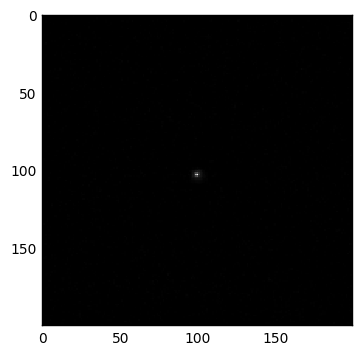

In [10]:
browse_images(filtered_images)

In [11]:
values = np.array(filtered_images)

In [13]:
from scipy.interpolate import RegularGridInterpolator
# focal plane spacing is 100um
# pixel pitch 0.8639 pixels/um = 1.158 um/pixel
pnts = ((np.linspace(0,30*20.,31) -  (14*20.))[:-1],
        np.linspace(0,1.158*199,200) - (1.158*199/2.0),
        np.linspace(0,1.158*199,200) - (1.158*199/2.0))

#Voxel size: 0.7568x0.7568x2.9793 micron^3
#74 z-slices in original make psf twice as large so we can place the putative focal 
#plane on any slice.
total_z = 2.9793*(74*2)
w_h = 0.7568*1024
grid_z, grid_x, grid_y = np.mgrid[total_z*-0.5:total_z*0.5:74*2j,
                                  w_h*-0.5:w_h*0.5:1024j, 
                                  w_h*-0.5:w_h*0.5:1024j,]
PSF = RegularGridInterpolator(pnts, values, method='linear',bounds_error = False,fill_value = 0)

In [14]:
interp = PSF((grid_z,grid_x,grid_y))

In [15]:
import h5py

In [16]:
#!rm interpolated_PSF.hdf5

In [17]:
psf_file = h5py.File('interpolated_PSF.hdf5','a')

In [18]:
psf_data = psf_file.create_dataset('data',data = interp,compression = 'gzip')

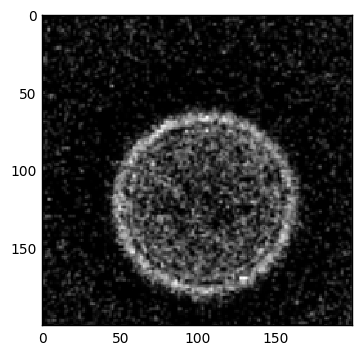

In [20]:
browse_images(psf_data[:,400:600,400:600])

In [22]:
import os

In [24]:
muscle_list = ['b1','b2','b3','i1','i2',
               'iii1','iii3','iii4',
               'hg1','hg2','hg3','hg4',
               'tpd','tpv','pr','nm','DVM1','DVM2','DVM3']

root_str = '../../confocal_reference/65G06_muscle_8bit_%s_layers/'
muscle_tiff_dict = dict()
for mn in muscle_list:
    files = [root_str%(mn) + '/65G06_muscle_8bit_%s_layers%s.tif'%(mn,i) for i in range(74)][::-1]
    tmp = np.array([ndimage.imread(f,mode = 'RGBA') for f in files])
    #convert to grayscale floats applying alpha channel
    threech = tmp[:,:,:,:3].astype(float) * tmp[:,:,:,3:4]
    muscle_tiff_dict[mn] = np.mean(threech,axis = 3)
    print mn

b1
b2
b3
i1
i2
iii1
iii3
iii4
hg1
hg2
hg3
hg4
tpd
tpv
pr
nm
DVM1
DVM2
DVM3


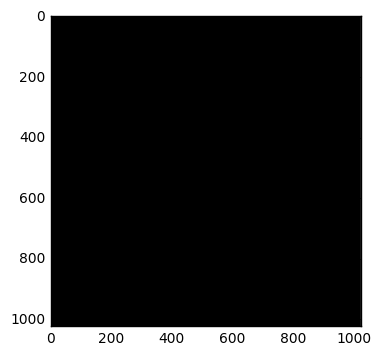

In [25]:
browse_images(muscle_tiff_dict['b3'])

In [29]:
def get_kernel(idx):
    ref_idx = 28
    psf_center_idx = len(psf_data)/2
    get_idx = (idx-ref_idx) + psf_center_idx
    img = np.array(psf_data[get_idx])
    return img/float(np.nansum(img))

In [30]:
def blur_slice(img,idx):
    """blurr a slice"""
    img = (img>0).astype(float)
    from scipy.signal import fftconvolve 
    kernel = get_kernel(idx)
    img_out = fftconvolve(img,kernel,mode = 'same')
    return img_out*float(sum(img))/float(np.nansum(img_out))

In [35]:
stk = [blur_slice(img,i) for i,img in enumerate(muscle_tiff_dict['b2'])]

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


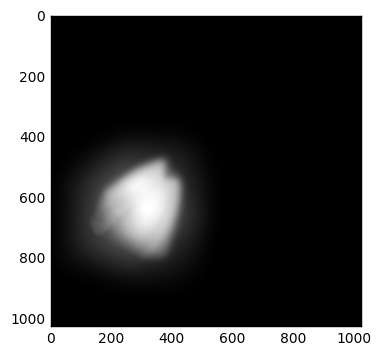

In [36]:
imshow(np.nanmean(stk,axis = 0),cmap =cm.gray)